In [1]:
#import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import xgboost as xgb

#prepare te data
def my_data_preparation(train_data):
    #merge training and store data
    all_data = pd.merge(train_data, store_data, how = 'left', on = 'Store')
    #convert 'Date' to datetime format
    all_data['Date'] = pd.to_datetime(train_data['Date'])
    #extract year, month, day of month, and week of year
    all_data['Year'] = all_data['Date'].dt.year
    all_data['Month'] = all_data['Date'].dt.month
    all_data['Day'] = all_data['Date'].dt.day
    all_data['WeekOfYear'] = all_data['Date'].dt.isocalendar().week.astype(np.int64)
    #fix type errors in the 'StateHoliday' column
    all_data['StateHoliday'] = all_data['StateHoliday'].replace(0.0, '0')
    #dummy encode all categorical data
    all_data = pd.get_dummies(all_data, columns = ['StoreType', 'Assortment', 'StateHoliday'])
    #select only columns with numerical data
    all_data = all_data.select_dtypes(include=np.number)
    #drop columns with too many nans and drop the 'Customers' column
    all_data = all_data.drop(columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Customers'])
    return all_data


#load data files
store_data = pd.read_csv("./data/store.csv")
train_data = pd.read_csv("./data/train.csv")
holdout_data_0 = pd.read_csv("./data/holdout_b29.csv")
#prepare the data
all_data = my_data_preparation(train_data)
all_holdout_data = my_data_preparation(holdout_data_0)
print(f'store_data.shape: {store_data.shape}')
print(f'train_data.shape: {train_data.shape}')
print(f'all_data.shape: {all_data.shape}')
#list of features
features =  ['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Open', 'Promo', 'SchoolHoliday', 
             'CompetitionDistance', 'Promo2', 
             'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
             'Assortment_a', 'Assortment_b', 'Assortment_c',
             'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
#list of features and target, the target is 'Sales'
features_and_target = list(features)
features_and_target.append('Sales')
print(features_and_target)
#drop all rows with nans in the relevant columns
numeric_data = all_data.dropna(axis = 0, subset = features_and_target)
#drop all rows with vanishing sales
numeric_data = numeric_data.loc[numeric_data['Sales'] != 0.0]
data = numeric_data
print(f'data.shape: {data.shape}')
#specify target and features
y = data.loc[:, 'Sales']
X = data.loc[:, features]
#set up the target encoder
#we target encode only the 'Store' column
ce_te = ce.TargetEncoder(cols = 'Store')
#find transform for target encoding
ce_te.fit(X, y)
#transform features
X = ce_te.transform(X)
#split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#specify features for the holdout data
holdout_data = all_holdout_data.loc[:, features]
#transform the holdout data
X_holdout = ce_te.transform(holdout_data)

/home/jakob/anaconda3/envs/minicomp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


store_data.shape: (1115, 10)
train_data.shape: (637774, 9)
all_data.shape: (637774, 23)
['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Sales']
data.shape: (438993, 23)


In [2]:
#How often are 'Sales' zero when shops are open?
shop_open = train_data.loc[train_data['Open'] == 1.0].dropna(axis = 0, subset = ['Sales'])
shop_open_zero_sales = shop_open.loc[shop_open['Sales'] == 0.0 ]
shop_open_zero_sales['Sales'].value_counts()

0.0    40
Name: Sales, dtype: int64

In [ ]:
numeric_data.shape: (438993, 23)

In [ ]:
#random forest regression
#set up random forest regressor
rfregr = RandomForestRegressor(max_depth=150, random_state=42)
#fit the training data
rfregr.fit(X_train, y_train)
#random forest prediction on the test data
predict_test = rfregr.predict(X_test)
#random forest prediction on the training data
predict_train = rfregr.predict(X_train)
#compute random forest score
print(f'RandomForest Score: {rfregr.score(X_test, y_test)}')
#compute random forest test RMSE
print(f'RandomForest test RMSE: {sqrt(mean_squared_error(y_test, predict_test))}')
#compute random forest train RMSE
print(f'RandomForest train RMSE: {sqrt(mean_squared_error(y_train, predict_train))}')
#compute random forest test RMSPE
diff = 1 - predict_test/y_test
RMSPE = sqrt(np.dot(diff,diff)/len(diff))
print(f'RandomForest test RMSPE: {RMSPE}')
#compute random forest train RMSPE
#diff = 1 - predict_train/y_train
#RMSPE = sqrt(np.dot(diff,diff)/len(diff))
#print(f'RandomForest train RMSPE: {RMSPE}')

In [ ]:
RandomForest test RMSPE: 0.17908077260534166

In [ ]:
#random forest prediction for the holdout data
rfregr.predict(X_holdout)

In [ ]:
X_holdout.isna().sum()

In [ ]:
X_holdout.shape

In [ ]:
#XGBoost regression
#set up xgb regressor
xgbr = xgb.XGBRegressor(max_depth=25,learning_rate=0.2,n_estimators=150,n_jobs=10, 
                        colsample_bytree=0.4,subsample=0.7,reg_alpha=10,reg_lambda=20)
#xgbr = xgb.XGBRegressor(max_depth=250,learning_rate=0.2,n_estimators=150,n_jobs=10, 
#                        colsample_bytree=0.4,subsample=0.7,reg_alpha=10,reg_lambda=20)
#fit the training data
xgbr.fit(X_train, y_train)
#xgb prediction on the test data
predict_test = xgbr.predict(X_test)
#xgb prediction on the test data
predict_train = xgbr.predict(X_train)
#compute xgb score
print(f'xgbr Score: {xgbr.score(X_test, y_test)}')
#compute xgb test RMSE
print(f'xgbr test RMSE: {sqrt(mean_squared_error(y_test, predict_test))}')
#compute xgb train RMSE
print(f'xgbr train RMSE: {sqrt(mean_squared_error(y_train, predict_train))}')
#compute xgb test RMSPE
diff = 1 - predict_test/y_test
RMSPE = sqrt(np.dot(diff,diff)/len(diff))
print(f'xgbr test RMSPE: {RMSPE}')
#compute xgb train RMSPE
#diff = 1 - predict_train/y_train
#RMSPE = sqrt(np.dot(diff,diff)/len(diff))
#print(f'xgbr train RMSPE: {RMSPE}')

In [ ]:
xgbr test RMSPE: 0.16122761297896557

In [ ]:
#xgb prediction for the holdout data
predict_holdout = xgbr.predict(X_holdout)
#generate 'ID' column for submission on kaggle
Ids = holdout_data_0.iloc[:, 0] + 1
#set up Data Frame which holds the 'Id' and 'Sales' columns
d = {'Id': Ids, 'Sales': predict_holdout}
df_holdout = pd.DataFrame(data = d)
#write holdout predition to a csv file
df_holdout.to_csv("data/predict_holdout.csv",index=False)
print(df_holdout.shape)

In [ ]:
print(df_holdout.tail())

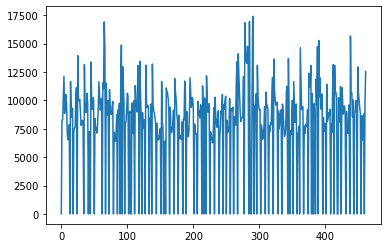

In [7]:
#store_1 = train_data.loc[train_data['Store'] == store_ids[3]].dropna()
#indices = [*range(len(store_1))]
#plt.plot(indices, store_1['Sales'])
#plt.show()